In [1]:
import numpy as np
import starry
import astropy.units as u
from astropy.time import Time
from astropy.table import vstack
import sys
import os
import scipy

from volcano.utils import get_body_ephemeris, get_body_vectors

np.random.seed(42)

starry.config.lazy = False

In [2]:
%matplotlib inline
%run notebook_setup.py

In [3]:
# Get 10 1hr observations of Io in eclipse/sunlight with 1sec cadence
start = Time("2009-01-01", format="isot")
stop = Time("2010-01-01", format="isot")
start_times = np.random.uniform(start.mjd, stop.mjd, 100)

eph_phase_ref = []
eph_phase_em = []

# This takes a while
nlightcurves = 30
i = 0
while len(eph_phase_ref) < nlightcurves:
    t = start_times[i]
    t_end = t + 2
    npts = int((t_end - t) * 24 * 60 * 60)  # 1sec cadence
    times = Time(np.linspace(t, t_end, npts), format="mjd")

    eph = get_body_ephemeris(times, body_id="501", step="1m", return_orientation=True)

    # Get only phase curves in reflected light
    mask_ref = np.all(
        [~eph["ecl_tot"], ~eph["ecl_par"], ~eph["occ_umbra"], ~eph["occ_sun"]], axis=0,
    )

    if mask_ref.sum() > 100.0:
        eph_phase_ref.append(eph[mask_ref][:100])
    i = i + 1

i = 0
while len(eph_phase_em) < nlightcurves:
    t = start_times[i]
    t_end = t + 2
    npts = int((t_end - t) * 24 * 60 * 60)  # 1sec cadence
    times = Time(np.linspace(t, t_end, npts), format="mjd")

    eph = get_body_ephemeris(times, body_id="501", step="1m", return_orientation=True)

    # Get phase curves in eclipse
    mask_ecl = np.all([eph["ecl_tot"], ~eph["occ_umbra"]], axis=0,)

    if mask_ecl.sum() > 100.0:
        eph_phase_em.append(eph[mask_ecl][:100])
    i = i + 1

In [4]:
eph_io_occ_ref = []
eph_jup_occ_ref = []
eph_io_occ_em = []
eph_jup_occ_em = []

i = 0
while len(eph_io_occ_ref) < nlightcurves:
    t = start_times[i]
    t_end = t + 2.0
    npts = int((t_end - t) * 24 * 60 * 60)  # 1sec cadence
    times = Time(np.linspace(t, t_end, npts), format="mjd")

    eph_io = get_body_ephemeris(
        times, body_id="501", step="1m", return_orientation=True
    )

    eph_jup = get_body_ephemeris(
        times, body_id="599", step="1m", return_orientation=False
    )

    # Get phase curves in eclipse
    mask = eph_io["occ_sun"]

    if mask.sum() > 0.0:
        eph_io_occ_ref.append(eph_io[mask])
        eph_jup_occ_ref.append(eph_jup[mask])

    i = i + 1

i = 0
while len(eph_io_occ_em) < nlightcurves:
    t = start_times[i]
    t_end = t + 2.0
    npts = int((t_end - t) * 24 * 60 * 60)  # 1sec cadence
    times = Time(np.linspace(t, t_end, npts), format="mjd")

    eph_io = get_body_ephemeris(
        times, body_id="501", step="1m", return_orientation=True
    )

    eph_jup = get_body_ephemeris(
        times, body_id="599", step="1m", return_orientation=False
    )

    # Get phase curves in eclipse
    mask = eph_io["occ_umbra"]

    if mask.sum() > 0.0:
        eph_io_occ_em.append(eph_io[mask])
        eph_jup_occ_em.append(eph_jup[mask])

    i = i + 1

In [123]:
def compute_design_matrix_phase(eph_list, reflected=True):
    ydeg = 20
    map = starry.Map(ydeg=ydeg, reflected=reflected)

    A_ = []

    for i in range(len(eph_list)):
        eph = eph_list[i]

        # Fix obliquity per light curve, this is fine because
        # obliquity and inclination vary on timescales of years
        obl = np.mean(eph["obl"])
        inc = np.mean(eph["inc"])
        map.obl = obl
        map.inc = inc

        theta = np.array(eph["theta"])
        xs = np.array(eph["xs"])
        ys = np.array(eph["ys"])
        zs = np.array(eph["zs"])

        # Compute the design matrix for a 1000 points per observing interval
        if reflected is True:
            m = map.design_matrix(theta=theta, xs=xs, ys=ys, zs=zs)

        else:
            m = map.design_matrix(theta=theta)

        A_.append(m)

    # Design matrix
    return np.concatenate(A_)


def compute_design_matrix_occ(eph_occulted_list, eph_occultor_list, reflected=False):
    ydeg = 20
    map = starry.Map(ydeg=ydeg, reflected=reflected)

    A_ = []

    for i in range(len(eph_occultor_list)):
        eph_occulted = eph_occulted_list[i]
        eph_occultor = eph_occultor_list[i]

        obl = np.mean(eph_occulted["obl"])
        inc = np.mean(eph_occulted["inc"])
        map.obl = obl
        map.inc = inc

        theta = np.array(eph_occulted["theta"])
        xs = np.array(eph_occulted["xs"])
        ys = np.array(eph_occulted["ys"])
        zs = np.array(eph_occulted["zs"])

        # Convert everything to units where the radius of Io = 1
        radius_occultor = eph_occultor["ang_width"] / eph_occulted["ang_width"]
        rel_ra = (eph_occultor["RA"] - eph_occulted["RA"]).to(u.arcsec) / (
            0.5 * eph_occulted["ang_width"].to(u.arcsec)
        )
        rel_dec = (eph_occultor["DEC"] - eph_occulted["DEC"]).to(u.arcsec) / (
            0.5 * eph_occulted["ang_width"].to(u.arcsec)
        )

        xo = -rel_ra
        yo = rel_dec
        zo = np.ones(len(yo))
        ro = np.mean(radius_occultor)

        if reflected is True:
            m = map.design_matrix(
                theta=theta, xs=xs, ys=ys, zs=zs, xo=xo, yo=yo, zo=zo, ro=ro
            )
        else:
            m = map.design_matrix(theta=theta, xo=xo, yo=yo, zo=zo, ro=ro)

        A_.append(m)

    # Remove parts when Io is behind jupiter
    A = np.concatenate(A_)
    y = np.zeros(int((ydeg + 1) ** 2))
    y[0] = 1.0
    f = A @ y[:, None]
    mask = (f == 0).flatten()

    return A[~mask, :]

In [124]:
# Phase curve emitted light
A_phase_em = compute_design_matrix_phase(eph_phase_em, reflected=False)

# Phase curves in reflected light
A_phase_ref = compute_design_matrix_phase(eph_phase_ref, reflected=True)

# Occultations in emitted light
A_occ_em = compute_design_matrix_occ(eph_io_occ_em, eph_jup_occ_em, reflected=False)

# Occultations in reflected light
A_occ_ref = compute_design_matrix_occ(eph_io_occ_ref, eph_jup_occ_ref, reflected=True)

# Combined in emitted light
A_occ_phase_em = np.concatenate([A_phase_em, A_occ_em])

# Combined in reflected light
A_occ_phase_ref = np.concatenate([A_phase_ref, A_occ_ref])

Pre-computing some matrices... Done.
Compiling `X`... Done.
Pre-computing some matrices... Done.
Compiling `X`... Done.
Pre-computing some matrices... Done.
Compiling `X`... Done.
Pre-computing some matrices... Done.
Compiling `X`... Done.


In [229]:
directory = "out"

if not os.path.exists(directory):
    os.makedirs(directory)

# Save design matrices to file
np.save(os.path.join(directory, "A_phase_em.npy"), A_phase_em)
np.save(os.path.join(directory, "A_phase_ref.npy"), A_phase_ref)
np.save(os.path.join(directory, "A_occ_em.npy"), A_occ_em)
np.save(os.path.join(directory, "A_occ_ref.npy"), A_occ_ref)
np.save(os.path.join(directory, "A_occ_phase_em"), A_occ_phase_em)
np.save(os.path.join(directory, "A_occ_phase_ref.npy"), A_occ_phase_ref)

### Mutual occultations of Galilean moons

In [8]:
search_windows = np.linspace(start.mjd, stop.mjd, 200)


def find_occultations(eph_io, eph_occultor):
    # Convert everything to units where the radius of Io = 1
    radius_occultor = eph_occultor["ang_width"] / eph_io["ang_width"]
    rel_ra = (eph_occultor["RA"] - eph_io["RA"]).to(u.arcsec) / (
        0.5 * eph_io["ang_width"].to(u.arcsec)
    )
    rel_dec = (eph_occultor["DEC"] - eph_io["DEC"]).to(u.arcsec) / (
        0.5 * eph_io["ang_width"].to(u.arcsec)
    )

    xo = -rel_ra
    yo = rel_dec
    ro = np.mean(radius_occultor)

    eps = 0.1
    mask = np.sqrt(xo ** 2 + yo ** 2) < (ro + 1 + eps)

    return mask


# Store ephemeris
mut_eur_ref = []
mut_gan_ref = []
mut_cal_ref = []

mut_eur_em = []
mut_gan_em = []
mut_cal_em = []

# Iterate over each time window, get ephemeris for all moons and search
# for occultations, this takes a few hours
for i in range(len(search_windows) - 1):
    t_start = search_windows[i]
    t_end = search_windows[i + 1]
    npts = int((t_end - t_start) * 24 * 60 * 60)  # 1sec cadence

    times = Time(np.linspace(t_start, t_end, npts), format="mjd")

    eph_io = get_body_ephemeris(
        times, body_id="501", step="1m", return_orientation=True
    )
    eph_eur = get_body_ephemeris(
        times, body_id="502", step="1m", return_orientation=False
    )
    eph_gan = get_body_ephemeris(
        times, body_id="503", step="1m", return_orientation=False
    )
    eph_cal = get_body_ephemeris(
        times, body_id="504", step="1m", return_orientation=False
    )

    # Select times when Io is not occulted by Jupiter and not in eclipse
    mask = np.all([eph_io["occ_umbra"], eph_io["occ_sun"], eph_io["ecl_par"]], axis=0)

    eph_io = eph_io[~mask]
    eph_eur = eph_eur[~mask]
    eph_gan = eph_gan[~mask]
    eph_cal = eph_cal[~mask]

    # Find occultations with each of the moons
    mask_eur = find_occultations(eph_io, eph_eur)
    mask_gan = find_occultations(eph_io, eph_gan)
    mask_cal = find_occultations(eph_io, eph_cal)

    if mask_eur.sum() > 0:
        mask_ecl = eph_io[mask_eur]["ecl_tot"] > 0.0
        # Split reflected and emitted light ephemeris
        if np.all(mask_ecl):
            mut_eur_em.append([eph_io[mask_eur][mask_ecl], eph_eur[mask_eur][mask_ecl]])
        else:
            mut_eur_ref.append([eph_io[mask_eur], eph_eur[mask_eur]])
    if mask_gan.sum() > 0:
        mask_ecl = eph_io[mask_gan]["ecl_tot"] > 0.0
        if np.all(mask_ecl):
            mut_gan_em.append([eph_io[mask_gan][mask_ecl], eph_gan[mask_gan][mask_ecl]])
        else:
            mut_gan_ref.append([eph_io[mask_gan], eph_gan[mask_gan]])
    if mask_cal.sum() > 0:
        mask_ecl = eph_io[mask_cal]["ecl_tot"] > 0.0
        if np.all(mask_ecl):
            mut_cal_em.append([eph_io[mask_cal][mask_ecl], eph_cal[mask_cal][mask_ecl]])
        else:
            mut_cal_ref.append([eph_io[mask_cal], eph_cal[mask_cal]])

In [126]:
# Europa
A_mut_eur_em = compute_design_matrix_occ(
    [eph[0] for eph in mut_eur_em], [eph[1] for eph in mut_eur_em], reflected=False
)

A_mut_eur_ref = compute_design_matrix_occ(
    [eph[0] for eph in mut_eur_ref], [eph[1] for eph in mut_eur_ref], reflected=True
)

# Ganymede
# A_mut_gan_em = compute_design_matrix_occ([eph[0] for eph in mut_gan_em],
#                                          [eph[1] for eph in mut_gan_em],
#                                          reflected=False)
A_mut_gan_ref = compute_design_matrix_occ(
    [eph[0] for eph in mut_gan_ref], [eph[1] for eph in mut_gan_ref], reflected=True
)

# Callisto
# A_mut_cal_em = compute_design_matrix_occ([eph[0] for eph in mut_cal_em],
#                                          [eph[1] for eph in mut_cal_em],
#                                          reflected=False)
A_mut_cal_ref = compute_design_matrix_occ(
    [eph[0] for eph in mut_cal_ref], [eph[1] for eph in mut_cal_ref], reflected=True
)

A_mut_em = np.concatenate([A_mut_eur_em])
A_mut_ref = np.concatenate([A_mut_eur_ref, A_mut_gan_ref, A_mut_cal_ref])

Pre-computing some matrices... Done.
Compiling `X`... Done.
Pre-computing some matrices... Done.
Compiling `X`... Done.
Pre-computing some matrices... Done.
Compiling `X`... Done.
Pre-computing some matrices... Done.
Compiling `X`... Done.


In [230]:
np.save(os.path.join(directory, "A_mut_em.npy"), A_mut_em)
np.save(os.path.join(directory, "A_mut_ref.npy"), A_mut_ref)

In [185]:
from scipy.linalg import cho_factor, cho_solve


def compute_posterior_shrinkage(A, avg_across_m=True, snr=100):
    """
    Computes the posterior covariance matrix for a given design matrix
    and data covariance matrix and returns the posterio shrinkage avaraged
    across coefficients with different m-s. The posterior shrinkage in this case
    is defined as 1 - sigma_post^2/sigma_prior^2 where sigma_post^2 and 
    sigma_prior^2 are the entries on the diagonal over the posterior and
    prior covariance matrices respectively.
    """
    ncoeff = len(A[0, :])
    ydeg = int(np.sqrt(ncoeff) - 1)

    y = np.zeros(ncoeff)[:, None]
    y[0] = 1.0
    y[1:, 0] = 0.01 * np.random.rand(ncoeff - 1)
    f = (A @ y).flatten()
    signal = np.max(f) - np.min(f)
    ferr = np.ones(len(f)) * signal / snr

    FCInv = scipy.sparse.diags(1.0 / ferr ** 2, 0)

    # Prior covariance
    Ldiag = 0.5 ** 2 * np.ones(ncoeff)
    Ldiag[0] = 1.0
    L = np.diag(Ldiag)
    LInv = np.diag(1.0 / Ldiag)

    SIGMAInv = np.dot(A.T, FCInv.dot(A)) + LInv
    cho_SIGMAInv = cho_factor(SIGMAInv)
    SIGMA = cho_solve(cho_SIGMAInv, np.eye(ncoeff))

    # Compute posterior shrinkage
    SIGMAdiag = np.diag(SIGMA)

    post_shrinkage = 1.0 - np.diag(SIGMA) / np.diag(L)

    post_shrinkage_mean = np.zeros(ydeg + 1)

    if avg_across_m:
        start = 0
        for l in range(ydeg + 1):
            post_shrinkage_mean[l] = np.mean(
                post_shrinkage[start : int(start + 2 * l + 1)]
            )
            start += 2 * l + 1
        return post_shrinkage_mean

    else:
        ls = np.floor(np.sqrt(np.arange(int((ydeg + 1) ** 2))))

        return ls, post_shrinkage

In [186]:
s_phase_em = compute_posterior_shrinkage(A_phase_em)
s_phase_ref = compute_posterior_shrinkage(A_phase_ref)
s_occ_emitted = compute_posterior_shrinkage(A_occ_em)
s_occ_ref = compute_posterior_shrinkage(A_occ_ref)
s_occ_phase_em = compute_posterior_shrinkage(A_occ_phase_em)
s_occ_phase_ref = compute_posterior_shrinkage(A_occ_phase_ref)
s_mut_em = compute_posterior_shrinkage(A_mut_em)
s_mut_ref = compute_posterior_shrinkage(A_mut_ref)

_s_phase_em = compute_posterior_shrinkage(A_phase_em, snr=10)
_s_phase_ref = compute_posterior_shrinkage(A_phase_ref, snr=10)
_s_occ_emitted = compute_posterior_shrinkage(A_occ_em, snr=10)
_s_occ_ref = compute_posterior_shrinkage(A_occ_ref, snr=10)
_s_occ_phase_em = compute_posterior_shrinkage(A_occ_phase_em, snr=10)
_s_occ_phase_ref = compute_posterior_shrinkage(A_occ_phase_ref, snr=10)
_s_mut_em = compute_posterior_shrinkage(A_mut_em, snr=10)
_s_mut_ref = compute_posterior_shrinkage(A_mut_ref, snr=10)

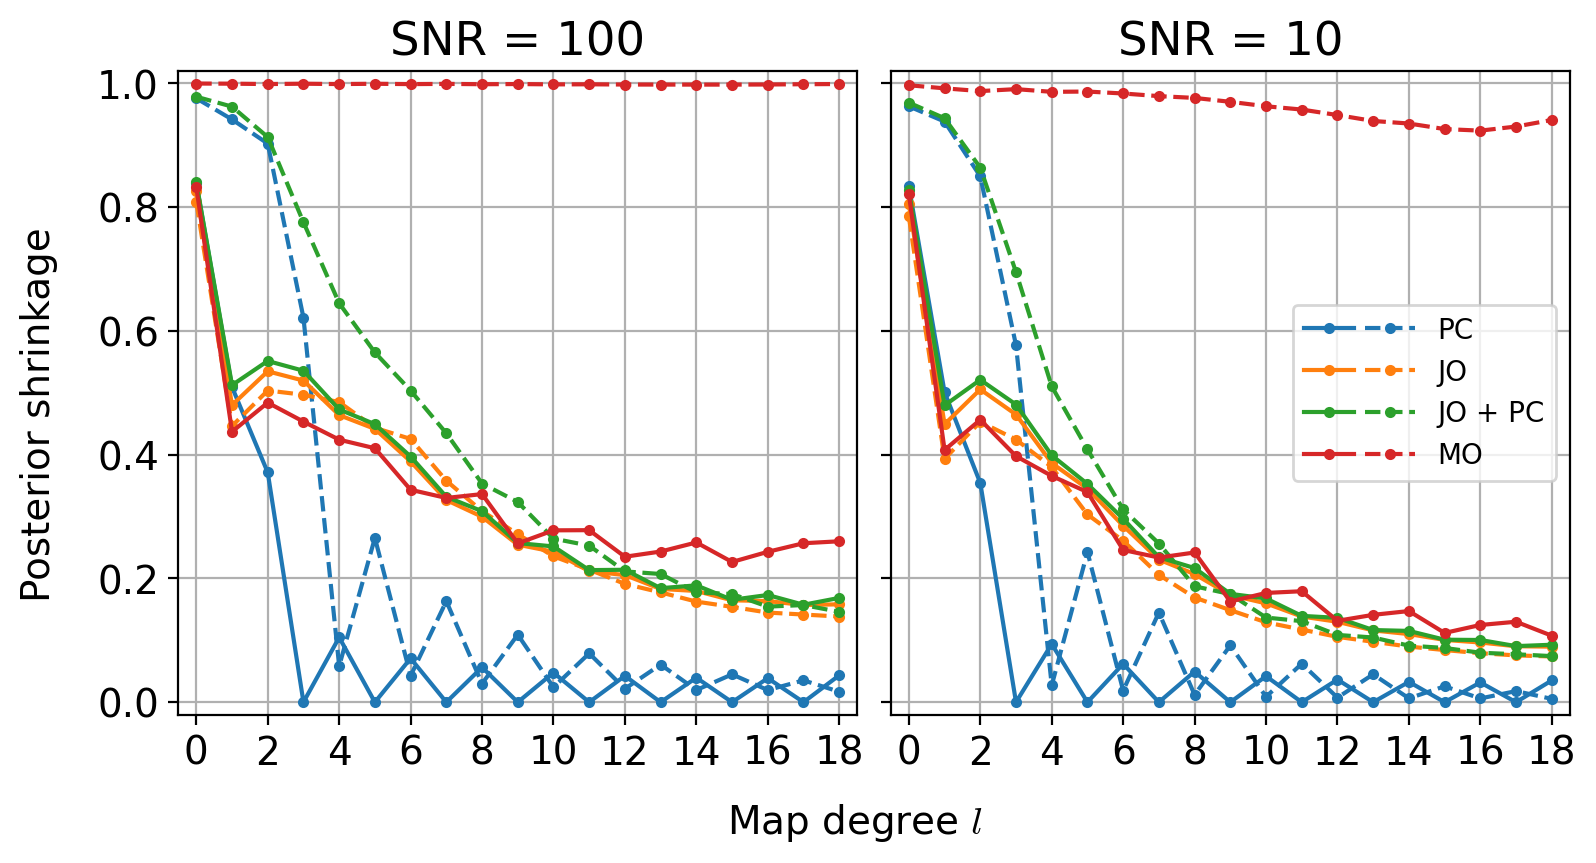

In [228]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
fig.tight_layout()
fig.subplots_adjust(wspace=0.05)

lcut = 19

(p1,) = ax[0].plot(s_phase_em[:lcut], "C0.-")
(p2,) = ax[0].plot(s_phase_ref[:lcut], "C0.--")
(p3,) = ax[0].plot(s_occ_emitted[:lcut], "C1.-")
(p4,) = ax[0].plot(s_occ_ref[:lcut], "C1.--")
(p5,) = ax[0].plot(s_occ_phase_em[:lcut], "C2.-")
(p6,) = ax[0].plot(s_occ_phase_ref[:lcut], "C2.--")
(p7,) = ax[0].plot(s_mut_em[:lcut], "C3.-")
(p8,) = ax[0].plot(s_mut_ref[:lcut], "C3.--")

ax[1].legend(
    [(p1, p2), (p3, p4), (p5, p6), (p7, p8)],
    ["PC", "JO", "JO + PC", "MO"],
    numpoints=1,
    handler_map={tuple: HandlerTuple(ndivide=None)},
    handlelength=4,
    prop={"size": 10},
    loc="center right",
)

ax[1].plot(_s_phase_em[:lcut], "C0.-", label="PC")
ax[1].plot(_s_phase_ref[:lcut], "C0.--")
ax[1].plot(_s_occ_emitted[:lcut], "C1.-", label="JO")
ax[1].plot(_s_occ_ref[:lcut], "C1.--")
ax[1].plot(_s_occ_phase_em[:lcut], "C2.-", label="JO + PC")
ax[1].plot(_s_occ_phase_ref[:lcut], "C2.--")
ax[1].plot(_s_mut_em[:lcut], "C3.-", label="MO")
ax[1].plot(_s_mut_ref[:lcut], "C3.--")


for a in ax.flatten():
    a.grid()
    a.set_ylim(-0.02, 1.02)
    a.set_xlim(-0.5, 18.5)
    a.set_xticks(np.arange(0, 19, 2))

ax[0].set_title("SNR = 100")
ax[1].set_title("SNR = 10")

fig.text(0.5, -0.01, r"Map degree $l$", ha="center", va="center")
fig.text(-0.01, 0.5, "Posterior shrinkage", ha="center", va="center", rotation=90)

plt.savefig("../paper/figures/nullspace.pdf", bbox_inches="tight")